# SF Police Incidents

A short demo analysis using [SF police incidents data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) from 2018 to present (early 2019 at time of writing).

In this demo, we'll cover some typical steps in the exploratory data analysis process. We'll start by leveling up on the data and some basic data quality checks, and then move on to analyzing a subset of incidents.

A critical first step in any analysis involves searching for and reviewing background material such as a data dictionary. It may also require phone calls to source agencies and experts who can help you make sense of the data. 

A review of the [data dictionary for the police incidents](https://bit.ly/2x7Ta2P) reveals that this data can be tricky to work with. The documentation states that each incident can have multiple records, one for each type of infraction reported:

> For example, an officer may have a warrant for an arrest
and while making the arrest discovers narcotics in the individual’s possession. The officer would record an incident code for the warrant as well as the discovery of narcotics.

Further, the data contains supplemental reports that correct or update initial reports. For these reasons, careful handling would be required to avoid over-counting incidents.

This example analysis sidesteps these issues by focusing on a subset of data without duplicate records (see below for related data vetting).

## Data import

The SFPD data can be downloaded by clicking `Export` and grabbing the link for a plain-old `CSV`:

![export-csv](img/download_data.png)


In [1]:
from datetime import datetime as dt
import pandas as pd
%matplotlib inline

We could read the data directly from the web using code such as below:

```
csv_url = 'https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD'
incidents = pd.read_csv(csv_url)
```

But let's be kind to the `sfgov.org` servers and read from a locally saved copy. Also, it's important to save a version of the data at the point in time the analysis was performed.

In [3]:
# Note we use the parse_dates parameter to convert the 
# date field values to datetime objects
local_file = 'data/sfpd_incidents_2018_to_present_20190228.csv'
incidents = pd.read_csv(local_file, parse_dates=['Report Datetime', 'Incident Date', 'Incident Datetime'])

In [4]:
# Make columns snake_case to simplify downstream code
incidents.columns = [col.lower().replace(' ', '_') for col in incidents.columns]

## Getting acquainted with the data

Let's get acquainted with the columns using `info()`. 

At first glance, this a nicely structured dataset with lots of metadata to support a variety of analyses. A few that jump out are the incident category/subcategory fields, date and time-based fields, and geography-oriented fields:

* incident_category
* incident_subcategory
* incident_date
* incident_day_of_week
* police_district
* latitude
* longitude
* point

In [5]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176242 entries, 0 to 176241
Data columns (total 26 columns):
incident_datetime          176242 non-null datetime64[ns]
incident_date              176242 non-null datetime64[ns]
incident_time              176242 non-null object
incident_year              176242 non-null int64
incident_day_of_week       176242 non-null object
report_datetime            176242 non-null datetime64[ns]
row_id                     176242 non-null int64
incident_id                176242 non-null int64
incident_number            176242 non-null int64
cad_number                 135931 non-null float64
report_type_code           176242 non-null object
report_type_description    176242 non-null object
filed_online               37841 non-null object
incident_code              176242 non-null int64
incident_category          176225 non-null object
incident_subcategory       176225 non-null object
incident_description       176242 non-null object
resolution          

## Data vetting

Before diving into analysis, we need to do some preliminary data quality checks. Dirty data [comes in many flavors](https://github.com/Quartz/bad-data-guide). A few key questions to always ask:

* Are there any missing or malformed values?
* Are there any unexpected values?
* Are there duplicate records?

These questions often must be investigated multiple times: once for the full data set, and then again for analyses focusing on subsets of data.

It's quite common to have some dirty data in a large data set. But if the dirty records clearly have no bearing on the subset of data that you're targeting, it could be safe to ignore those records. Or perhaps these records are relevant to your analysis, but you determine it is possible to correct them in consultation with the source agency.

Dirty data is a fact of life, but we can't let it put us into a state of "analysis paralysis." With careful and methodical data vetting, we can avoid landmines and make informed decisions about when it's safe to fix or work around dirty data.

### Incident date vetting

We mentioned earlier that incident dates will be important in our analysis. Let's do some basic sanity checking on the `incident_date` field.

> Note that this field was originally a string in the format YYYY/MM/DD. We 
> automatically converted it upon import using the `parse_dates` parameter for [read_csv](http://pandas-docs.github.io/pandas-docs-travis/reference/api/pandas.read_csv.html#pandas-read-csv).

In [7]:
incidents.incident_date.describe()

count                  176242
unique                    423
top       2018-08-01 00:00:00
freq                      543
first     2018-01-01 00:00:00
last      2019-02-27 00:00:00
Name: incident_date, dtype: object

All records appear to have dates and fall within the expected range of 2018 and early 2019.

When we later analyze incidents by day of week, we'll need the ability to sort them correctly. The existing `incident_day_of_week` column is a string, and will be useful as a readable label for grouping and charting purposes, but because it's a plain string, we will not be able to use it to sort the days correctly.

Below we'll add a new column to the data to store the number for the day of week. This can be derived from the `incident_date`, which contains datetime objects. These datetimes have a handy [weekday method](https://docs.python.org/3/library/datetime.html#datetime.date.weekday) that returns an integer for the day of the week. We'll use the DataFrame's [apply method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html#pandas-dataframe-apply) to add the new column, in a similar fashion to the [example](http://www.firstpythonnotebook.org/cleaning/index.html#chapter-16-hello-cleaning) from the First Python Notebook.

In [8]:
# Add numeric day of week column to all records for sorting purposes
incidents['daynum'] = incidents.incident_date.apply(lambda x: x.weekday())

### Category/Subcategory Vetting

We got an overall record count earlier when we ran `incidents.info()`. Let's compare that number to the count of records with category and subcategory information.


In [9]:
incidents[['incident_category', 'incident_subcategory']].describe()

,incident_category,incident_subcategory
count,176225,176225
unique,50,75
top,Larceny Theft,Larceny - From Vehicle
freq,55071,32077


Twenty or so records in our overall data set are missing category/subcategory labels. This small number likely won't affect statistics on the full data set, but it could lead to incorrect conclusions such as an undercount or incorrect ranking when dealing with categories that have smaller incident counts. 

In a real project, we'd want to examine these records when dealing with small subsets of data to see if they can be safely ignored or properly labeled. 

We'd also want to thoroughly review the full list of categories/subcategories to guard against cases of misspellings or similar incident types that should be merged for the purpose of aggregation.

Here is some example code that could be used to get the full list of categories/subcategories:

```
incidents.groupby(["incident_category","incident_subcategory"]).row_id.count().reset_index().sort_values(["incident_category", "incident_subcategory"])
```

## Drunkenness by Police District

Let's say that we've explored the full list of categories and subcategories, and decided to analyze the `Drunkenness` subcategory, starting with a breakdown of incidents by police district.

### Data vetting

Step one involves a few quick sanity checks on the `police_district` field.

In [10]:
# Verify all records have a police district value
incidents.police_district.describe()

count      176242
unique         11
top       Central
freq        28184
Name: police_district, dtype: object

In [11]:
# List all police districts
districts = list(incidents.police_district.unique())
districts

['Northern',
 'Taraval',
 'Southern',
 'Richmond',
 'Mission',
 'Tenderloin',
 'Ingleside',
 'Central',
 'Bayview',
 'Park',
 'Out of SF']

In [12]:
len(districts)

11

All records have a value for the `police_district` field and there are 11 districts. One of these -- `Out of SF` -- is worth digging into further, especially if we plan to generate aggregate statistics for the full dataset. We will ignore this district for now, however, since there are no drunkenness incidents associated with this district (see below).  

### District analysis

Now we're ready to begin the analysis. Let's focus the analysis on records from 2018 -- the one full year of data -- and filter out the drunkenness incidents.

In [13]:
incidents_2018 = incidents[(incidents.incident_date >= '2018-01-01') & (incidents.incident_date <= '2018-12-31')]

In [14]:
# Filter the drunk records
drunk = incidents_2018[incidents_2018.incident_subcategory == 'Drunkenness']

#### More Data Vetting

At the top we mentioned the possibility of multiple/duplicate records per incident. Let's check to make sure that this subset of data does not contain duplicates. 

The below query [groups](http://www.firstpythonnotebook.org/groupby/index.html) records by `incident_id`, then [filters](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#filtration) for any groups with a count that is greater than one.

In [18]:
drunk.groupby(by='incident_id').filter(lambda x: len(x) > 1)

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,row_id,incident_id,incident_number,cad_number,...,resolution,intersection,cnn,police_district,analysis_neighborhood,supervisor_district,latitude,longitude,point,daynum


The above query should return an empty DataFrame, indicating that all `drunkenness` incidents are unique.

Before moving on to the district analysis, let's do one final data check on the `row_id` field.  This should be a unique value for each row, according to the [data dictionary](https://bit.ly/2x7Ta2P), so it will be useful for aggregation. Let's verify that `row_id` contains unique values and is present on all fields. Otherwise we risk generating incorrect counts. The number we get should match the overall record count.

In [19]:
incidents.row_id.nunique()

176242

The `row_id` column appears to be a unique value present on all rows. Let's proceed with a [groupby](http://www.firstpythonnotebook.org/groupby/index.html) operation to see which police districts have the highest number of `drunkenness` incident counts.

In [20]:
pd_grouped = drunk.groupby(by="police_district").row_id.count().reset_index().sort_values("row_id", ascending=False)
pd_grouped

,police_district,row_id
3,Mission,77
1,Central,47
7,Southern,45
4,Northern,31
9,Tenderloin,27
8,Taraval,17
2,Ingleside,14
5,Park,11
6,Richmond,11
0,Bayview,9


Let's also calculate the percentage of drunkenness incidents that occurred in each district.

We'll create a [lambda function](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to calculate the percentage for each row, and then [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html#pandas-dataframe-apply) it in a similar fashion to the [example](http://www.firstpythonnotebook.org/cleaning/index.html#chapter-16-hello-cleaning) from the First Python Notebook.

In [21]:
total_drunk = drunk.row_id.count()
pct_of_total = lambda grp: (grp.row_id / total_drunk) * 100
pd_grouped['pct'] = pd_grouped.apply(pct_of_total, axis=1)
pd_grouped

,police_district,row_id,pct
3,Mission,77,26.643599
1,Central,47,16.262976
7,Southern,45,15.570934
4,Northern,31,10.726644
9,Tenderloin,27,9.342561
8,Taraval,17,5.882353
2,Ingleside,14,4.844291
5,Park,11,3.806228
6,Richmond,11,3.806228
0,Bayview,9,3.114187


**Finding #1** The Mission District accounts for more than a quarter of the city's drunkenness incidents in 2018. 

As part of a real story, we would need to do some follow-up reporting and analysis to explore the the context behind this finding. Does the Mission District top the list because it has the most bars? Are police simply enforcing this crime more in the district? What do the district's enforcement figures for this type of incident look like over time? A combination of factors could be at play, and the reporter's job is to apply his or her source reporting and data skills to get the story behind this figure.

Before moving onto the next part of our analysis, let's dip our toes into some basic charting. Below we select the police district and percentages from our grouped data and display a horizontal bar chart.

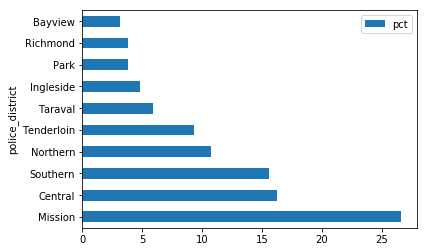

In [22]:
pd_grouped[['police_district', 'pct']].plot.barh('police_district')

## Drunkenness by day of week

The next part of our analysis looks at drunkenness by day of week. We include the `daynum` field that we added to the dataframe earlier so that we can properly order the days.

In [23]:
days_grped = drunk.groupby(by=["daynum", "incident_day_of_week"]).row_id.count().reset_index().sort_values('daynum')
days_grped

,daynum,incident_day_of_week,row_id
0,0,Monday,26
1,1,Tuesday,36
2,2,Wednesday,38
3,3,Thursday,38
4,4,Friday,43
5,5,Saturday,59
6,6,Sunday,49


Text(0, 0.5, 'incident counts')

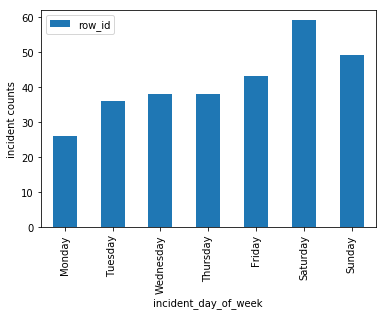

In [24]:
days_grped[['incident_day_of_week', 'row_id']].plot.bar('incident_day_of_week').set_ylabel("incident counts")

**Finding #2** The most drunkenness incidents occurred on Saturday and Sunday, respectively. 

It's likely that the Sunday incidents occurred in the early morning hours. Further analysis of incident times could shed light on this, but let's move on to some more charting examples.

### Charting Examples

Python has a number of charting libraries, each with a different set of strengths. One of the oldest and still most popular libraries is [matplotlib](https://matplotlib.org/index.html), which offers fine-grained control over charting elements. [Altair](https://altair-viz.github.io/) and [Seaborn](https://seaborn.pydata.org/) are popular alternatives that simplify the work of creating visualizations, so you should definitely check these out as well.

We'll stick with matplotlib for this tutorial. Below is a line chart that demonstrates a few of the many customization options offered by matplotlib.

Text(0, 0.5, 'Incident Counts')

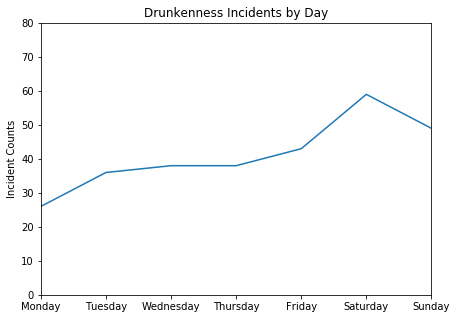

In [35]:
line_chart = days_grped.plot(
    x='incident_day_of_week',
    y='row_id', 
    title='Drunkenness Incidents by Day',
    legend=False,
    figsize=(7,5)
)
# Set the upper and lower bounds for the y-axis;
# otherwise it defaults to lowest and highest values in the data
line_chart.set_ylim(bottom=0, top=80) 
line_chart.set_xlabel("") # Set x-axis label to blank 
line_chart.set_ylabel("Incident Counts") 

And here's an example that puts a few chart variations side-by-side.

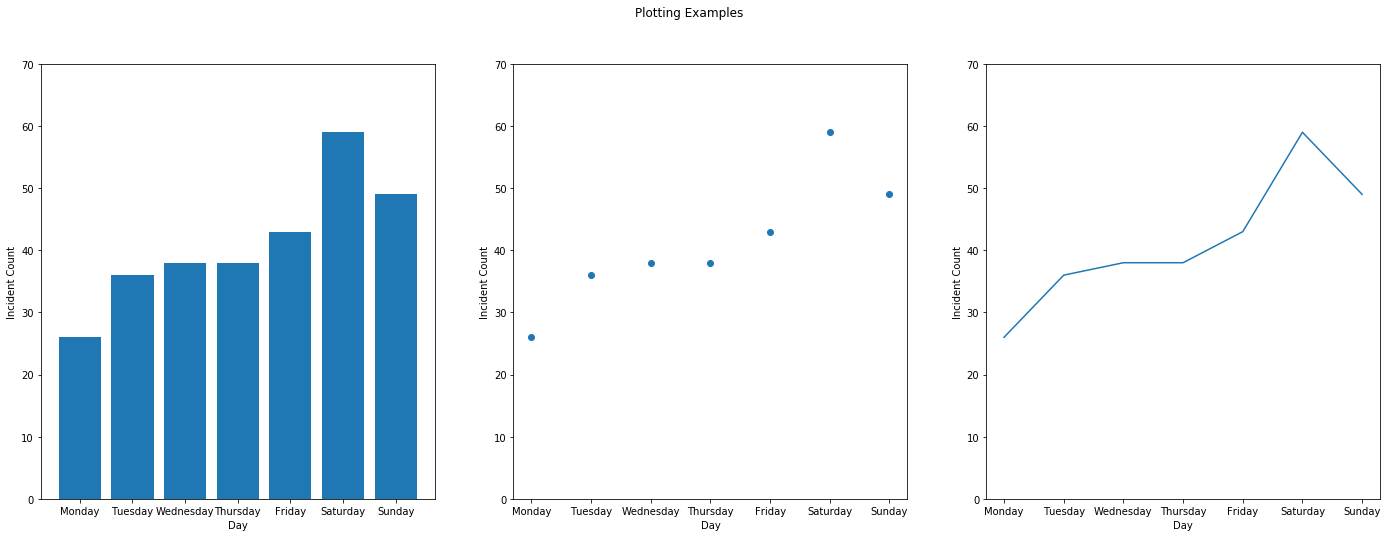

In [26]:
import matplotlib.pyplot as plt
kwargs = { 'xlabel': 'Day', 'ylabel': 'Incident Count'}
plt.figure(1, figsize=(24, 8))

plt.subplot(131, ylim=(0,70), **kwargs)
plt.bar(days_grped.incident_day_of_week, days_grped.row_id)

plt.subplot(132, ylim=(0,70), **kwargs)
plt.scatter(days_grped.incident_day_of_week, days_grped.row_id)

plt.subplot(133, ylim=(0,70), **kwargs)
plt.plot(days_grped.incident_day_of_week, days_grped.row_id)

plt.suptitle('Plotting Examples')
plt.show()

## Drunkenness by Month

Finally let's take a look at the incidents broken down by month.

**Finding #3** The most drunkenness incidents occurred in December. Follow-up reporting and analysis of incidents by day could help determine if New Year's festivities accounted for the higher number in this month.

Below we use the [dt method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) on the `incident_date` column in order to grab the month number on the the datetime objects.

In [36]:
monthly = drunk[['row_id']].groupby(drunk['incident_date'].dt.month).count()
monthly

,row_id
incident_date,
1,19
2,19
3,23
4,26
5,22
6,21
7,26
8,21
9,25


Finally, we chart the incidents by month, which more clearly shows December as the month with most incidents.

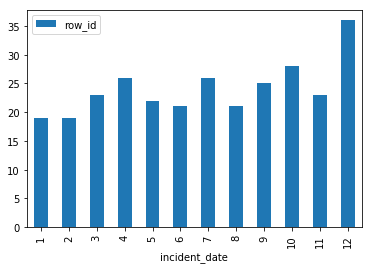

In [34]:
monthly.plot(kind="bar")